In [97]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import randint
import seaborn as sns
import numpy as np


In [96]:
!pip install seaborn --upgrade

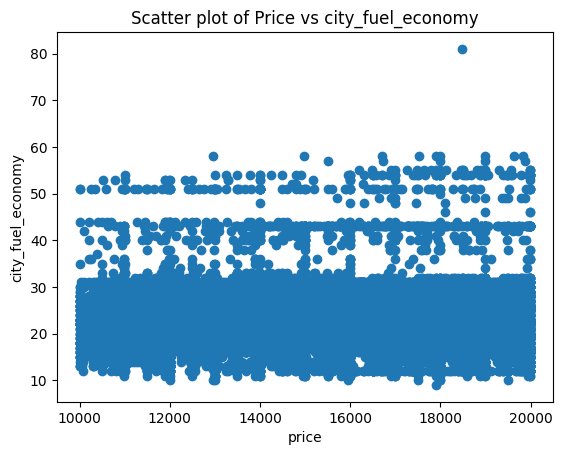

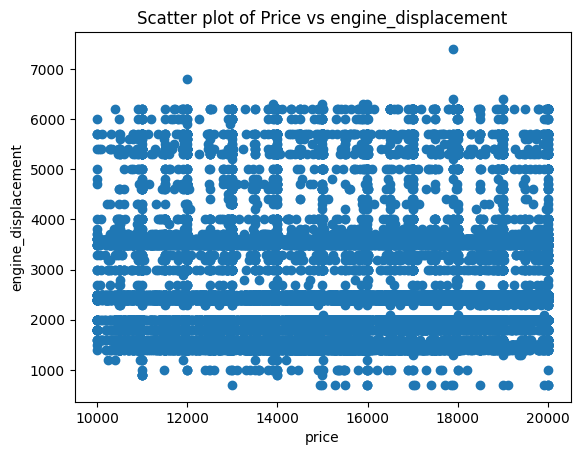

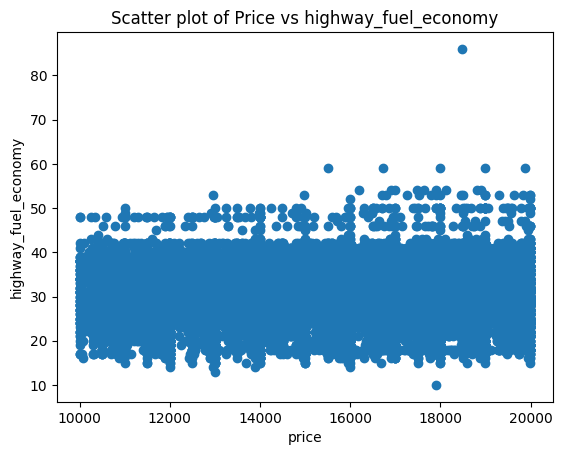

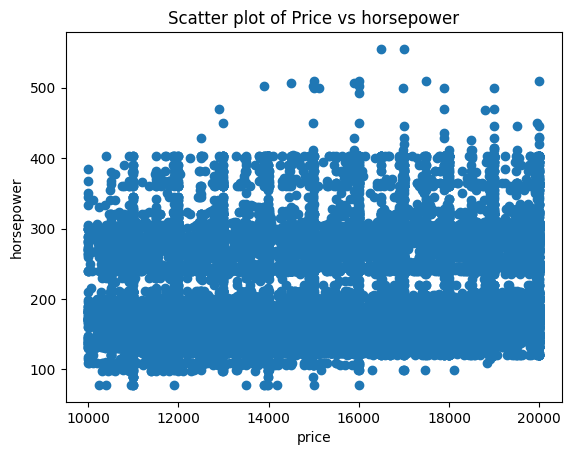

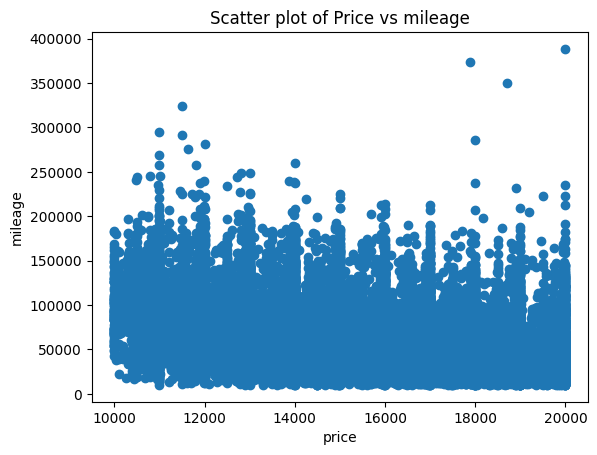

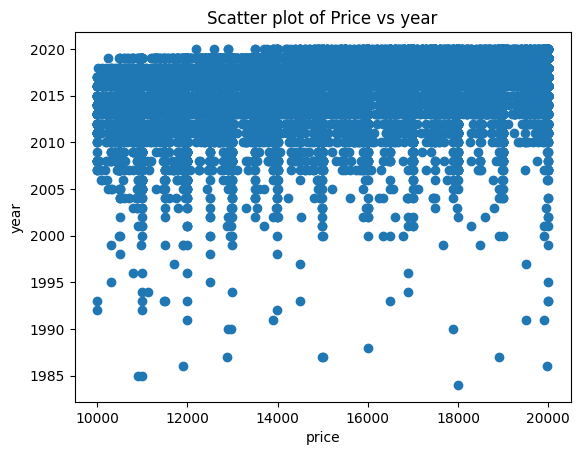

In [18]:
df_small = pd.read_csv(
    '/workspaces/ECON-424/Predic_2/424_F2025_PC2_small_train_data_v1.csv'
    )

for column in df_small.drop('price', axis=1).columns:
    plt.figure()
    plt.scatter(df_small['price'], df_small[column])
    plt.xlabel('price')
    plt.ylabel(column)
    plt.title(f'Scatter plot of Price vs {column}')
    
    plt.savefig(f"scatter_small_{column}.png")

In [ ]:
def make_hist(df):
    for column in df.columns:
        plt.figure()
        plt.hist(df[column], bins=30, edgecolor='k')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.title(f'Histogram of {column}')
        
        #plt.savefig(f"hist_small_{column}.png")

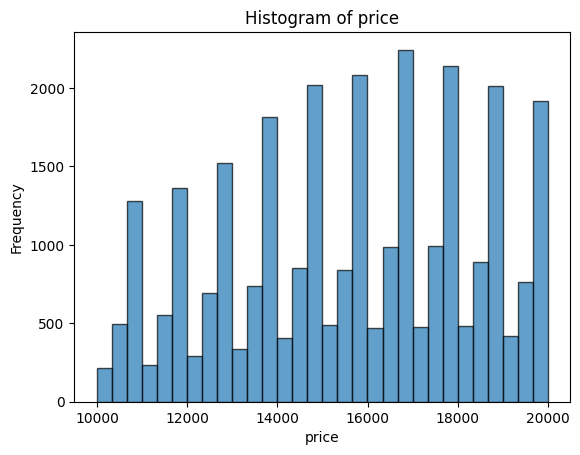

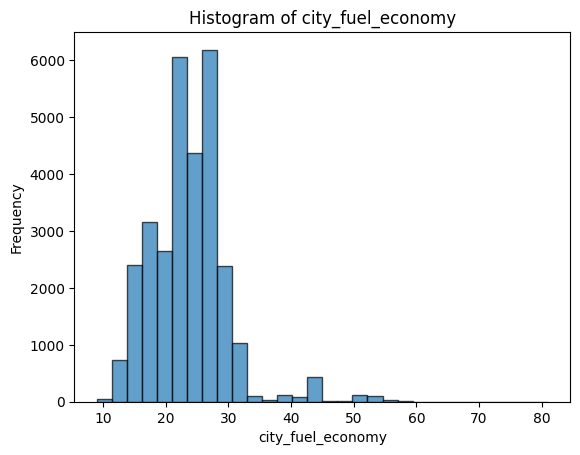

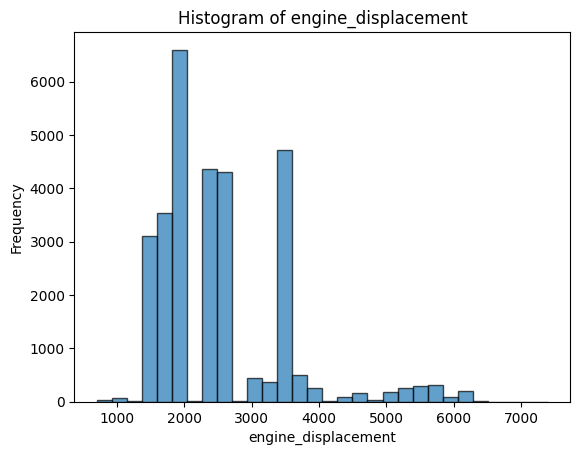

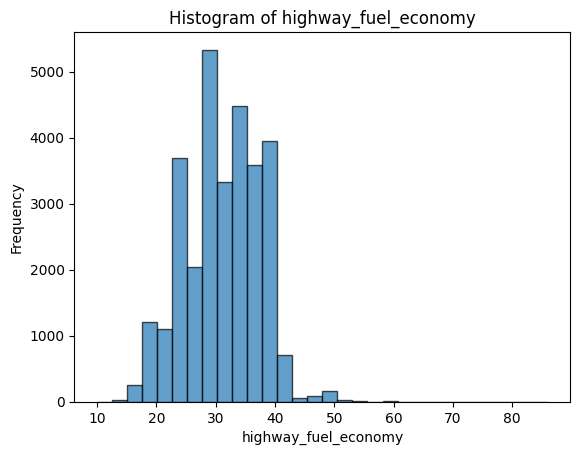

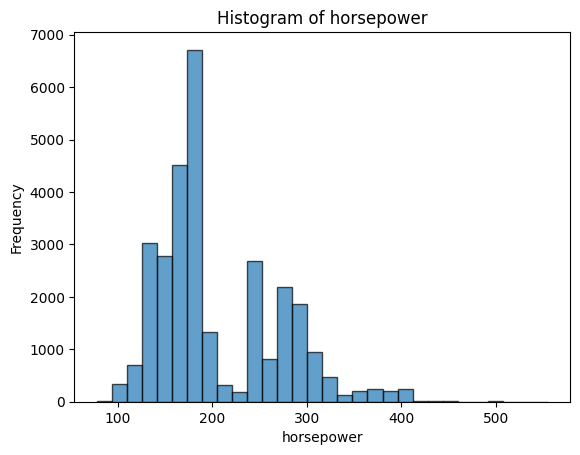

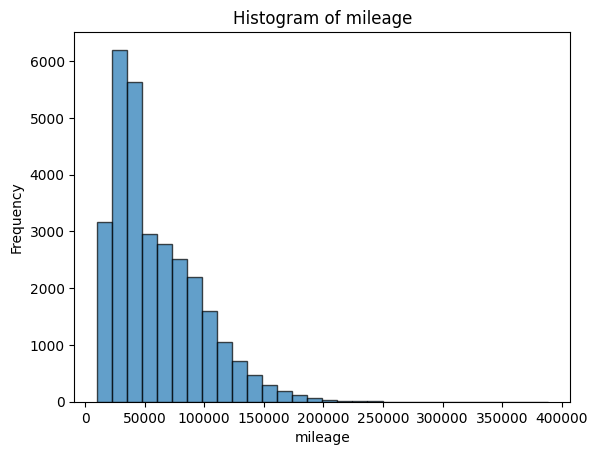

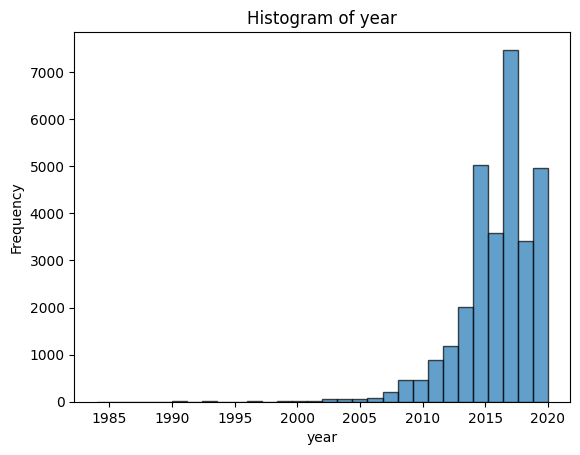

In [9]:
make_hist(df_small)


In [22]:
def preprocess_data(df):
    df['price'] = np.log(df['price'])
    df['age'] = 2025 - df['year']
    df['is_old'] = (df['year'] < 2010).astype(int)
    df['is_high_mileage'] = (df['mileage'] > 100000).astype(int)
    df['avg_fuel_efficiency'] = (df['city_fuel_economy'] + 
                                 df['highway_fuel_economy']) / 2
    df['mileage/year'] = df['mileage'] / df['age']
    df['engine/hp'] = df['engine_displacement'] / df['horsepower']
    return None
    



In [24]:
df_small

price  city_fuel_economy  engine_displacement  highway_fuel_economy  \
0      9.740439                 17                 3600                    25   
1      9.738023                 15                 5000                    21   
2      9.336268                 16                 4000                    22   
3      9.509556                 29                 1800                    37   
4      9.851878                 28                 2000                    37   
...         ...                ...                  ...                   ...   
29995  9.790431                 22                 2000                    30   
29996  9.615139                 17                 3600                    25   
29997  9.602315                 23                 2000                    30   
29998  9.543235                 17                 3500                    25   
29999  9.652137                 22                 2000                    29   

       horsepower  mileage  year  age  is_old  is_high_mileage  \
0             283    47706  2018    7       0                0   
1             360    67250  2014   11       0                0   
2             261   129241  2013   12       0                1   
3             124    39854  2018    7       0                0   
4             147    30297  2017    8       0                0   
...           ...      ...   ...  ...     ...              ...   
29995         252    51220  2017    8       0                0   
29996         283    79546  2018    7       0                0   
29997         164    48721  2017    8       0                0   
29998         365   108112  2014   11       0                1   
29999         240    52006  2015   10       0                0   

       avg_fuel_efficiency  mileage/year  engine/hp  
0                     21.0   6815.142857  12.720848  
1                     18.0   6113.636364  13.888889  
2                     19.0  10770.083333  15.325670  
3                     33.0   5693.428571  14.516129  
4                     32.5   3787.125000  13.605442  
...                    ...           ...        ...  
29995                 26.0   6402.500000   7.936508  
29996                 21.0  11363.714286  12.720848  
29997                 26.5   6090.125000  12.195122  
29998                 21.0   9828.363636   9.589041  
29999                 25.5   5200.600000   8.333333  

[30000 rows x 13 columns]

In [85]:
x_vals = df_final.drop(['price',
                        'city_fuel_economy',
                        'highway_fuel_economy'],axis=1)
y_vals = df_final['price']
x_train, x_test, y_train, y_test = \
    train_test_split(x_vals,y_vals,test_size=0.25)


In [27]:
model_lin = LinearRegression()
model_lin.fit(x_train,y_train)
y_pred_lin = model_lin.predict(x_test)
r2_lin = r2_score(y_test,y_pred_lin)
print("R2 for linear model:", r2_lin)

R2 for linear model: 0.3853521510520074


In [36]:
model_lasso = LassoCV()
model_lasso.fit(x_train,y_train)
y_pred_lasso = model_lasso.predict(x_test)
r2_lasso = r2_score(y_test,y_pred_lasso)
print("R2 for Lasso model:", r2_lasso)

R2 for Lasso model: 0.31897725479893846


In [38]:
model_ridge = RidgeCV()
model_ridge.fit(x_train,y_train)
y_pred_ridge = model_ridge.predict(x_test)
r2_ridge = r2_score(y_test,y_pred_ridge)
print("R2 for Ridge model:", r2_ridge)


R2 for Ridge model: 0.38537182883171284


In [89]:

param = {
    'max_depth': randint(2,35),
    'min_samples_split': randint(2,25),
    'min_samples_leaf': randint(1,35),
    'max_features': ['sqrt','log2',None]
}
rand_search = RandomizedSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_distributions=param, 
    n_iter=250, 
    cv=10, 
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    random_state=42
    )
rand_search.fit(x_train,y_train)
best_tree = rand_search.best_estimator_
y_pred_tree = best_tree.predict(x_test)
r2_tree = r2_score(y_test,y_pred_tree)
print("R2 for decision tree model:", r2_tree,
      "\nBest parameters:", rand_search.best_params_, rand_search.best_score_)

R2 for decision tree model: 0.5538547547315267 
Best parameters: {'max_depth': 15, 'max_features': None, 'min_samples_leaf': 15, 'min_samples_split': 9} -0.014888465987344331


In [49]:
def visualize_decision_tree(model, feature_names=None, class_names=None, figsize=(20, 10), show=True):
    '''
    Visualizes a decision tree model, displaying key information about each node, such as Gini Impurity, class distribution, and feature splits.
 
    Parameters:
    - model: The trained decision tree model (e.g., DecisionTreeClassifier or DecisionTreeRegressor).
    - feature_names: List of feature names. Default is None, which uses the feature index numbers.
    - class_names: List of class names (only relevant for classification problems). Default is None.
    - figsize: Tuple specifying the size of the plot. Default is (20, 10).
    - show: Boolean to decide if the plot should be shown. Default is True.
    '''
    plt.figure(figsize=figsize)
 
    # Plot the tree
    plot_tree(
        model, 
        filled=True,  # Color nodes based on class
        feature_names=feature_names,  # Label the feature names
        class_names=class_names,  # Label the class names (for classification)
        fontsize=10,  # Font size for text
        impurity=True,  # Display Gini impurity at each node
        proportion=False,  # Do not normalize sample counts
        rounded=True  # Rounded edges for the nodes
    )
    plt.show()

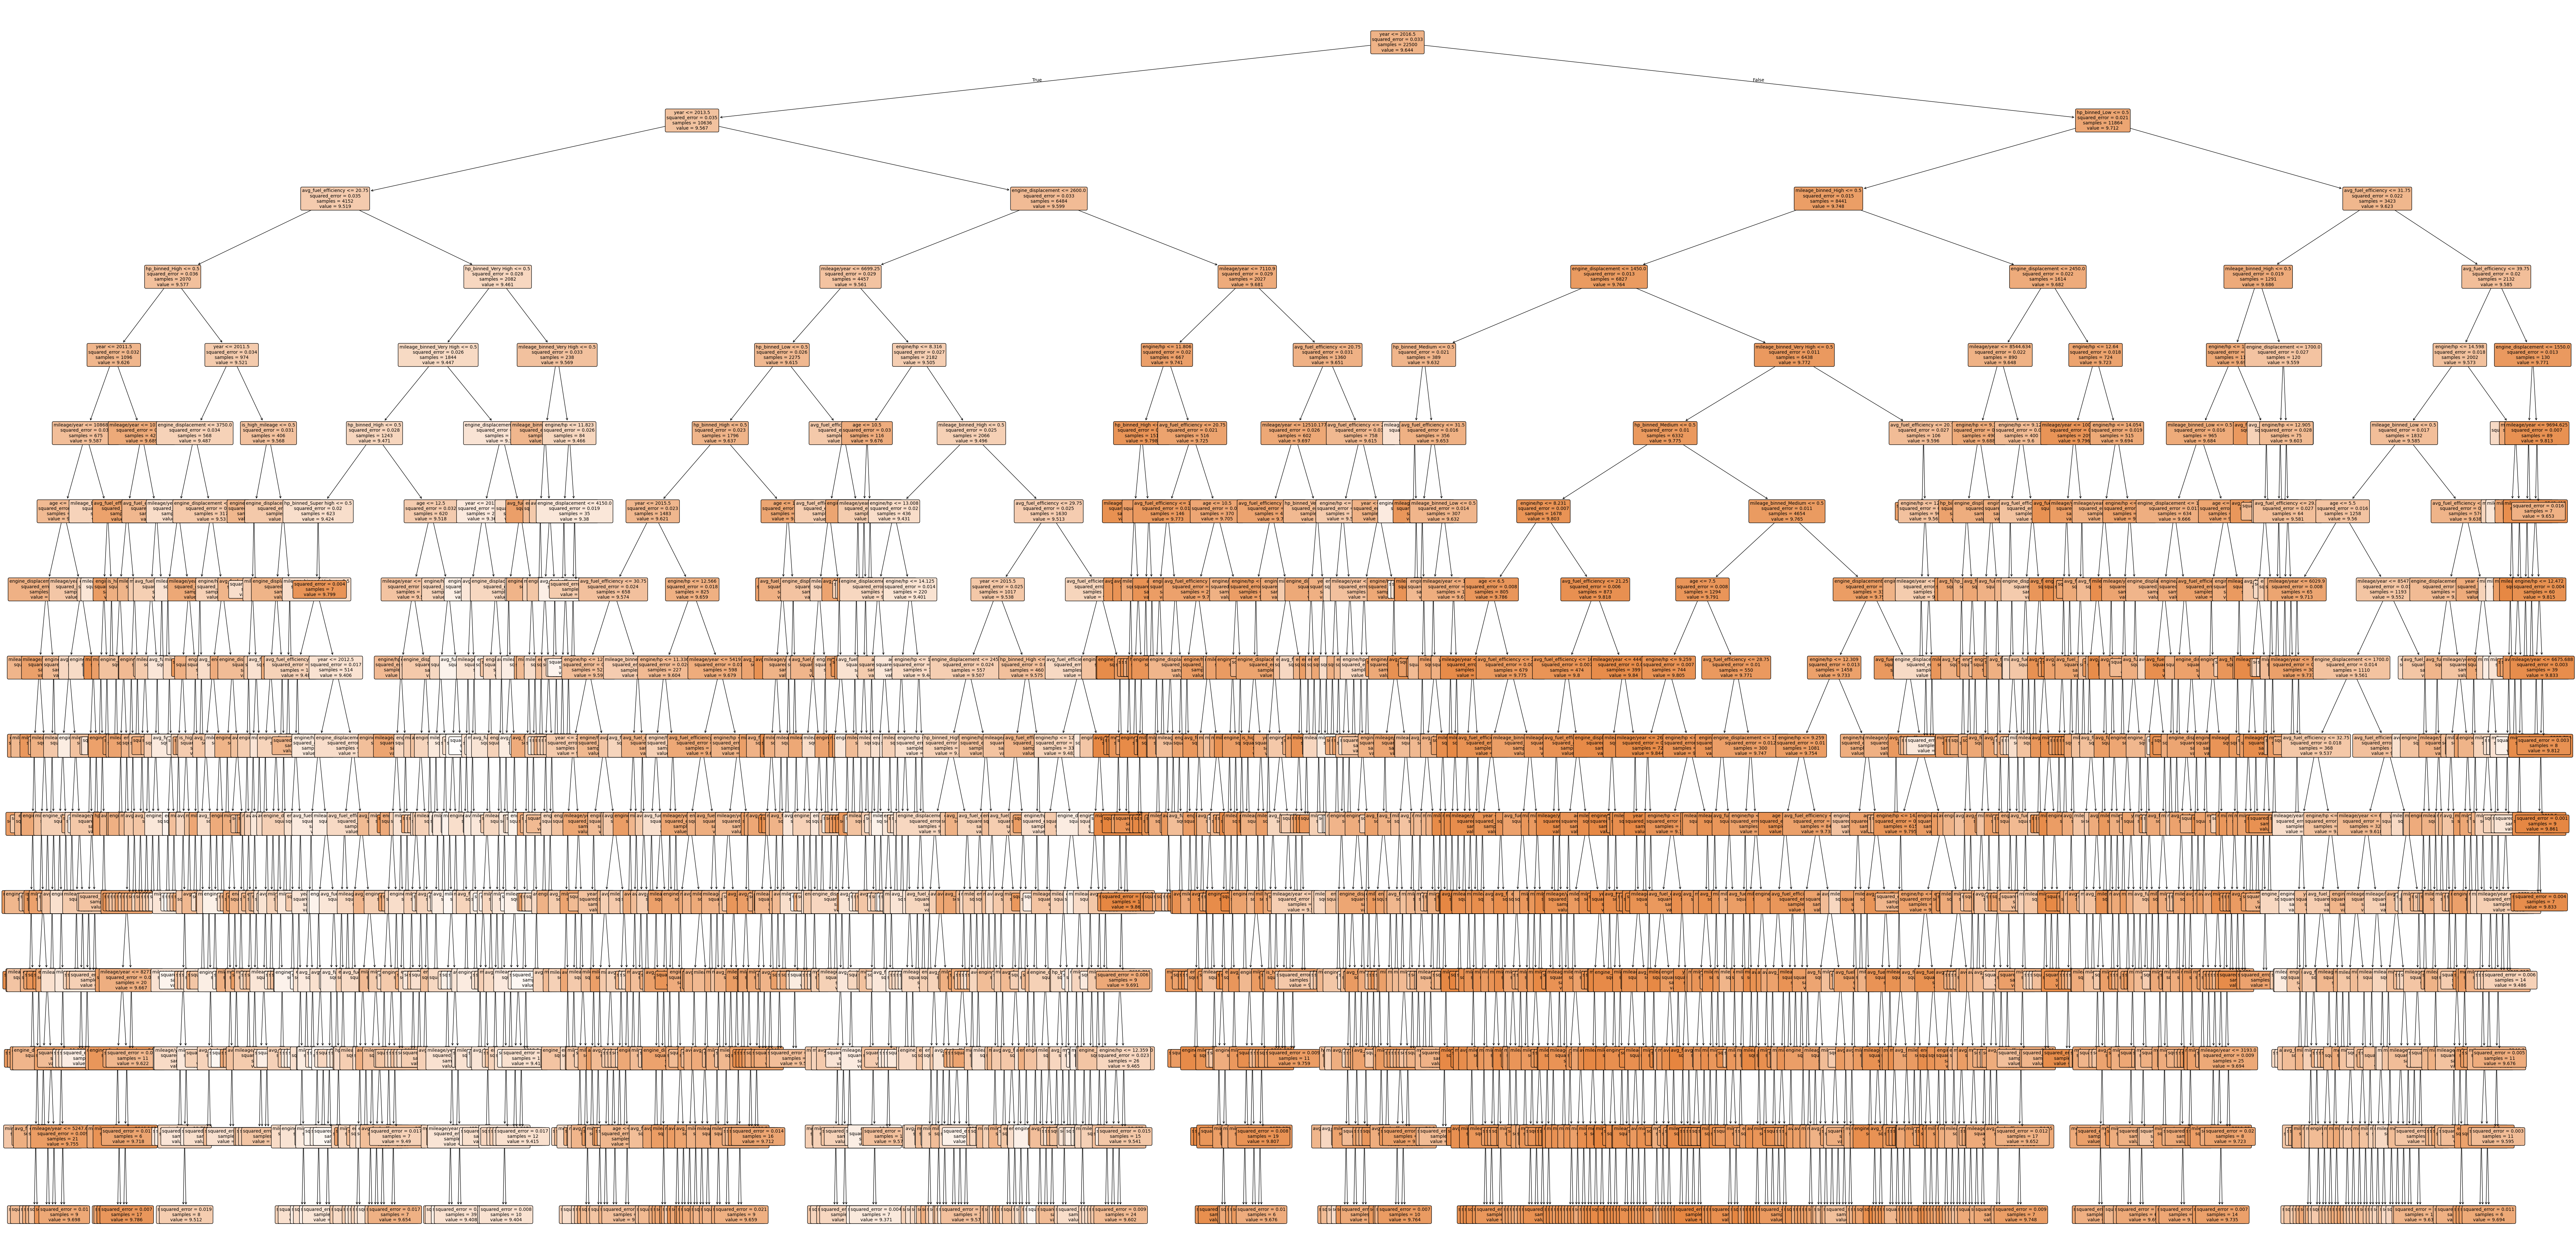

In [87]:
visualize_decision_tree(best_tree, feature_names=x_train.columns,figsize=(100,50))


In [81]:
df = df_small.copy()
df['mileage_binned'] = pd.cut(df['mileage'], 
                              bins=[0, 25000, 50000, 100000, 200000, float('inf')],
                              labels=['Low', 'Medium', 'High', 'Very High', 'Extreme'])
mileage_binned_cat = df[['mileage_binned']]
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(mileage_binned_cat)
mileage_encoded = pd.DataFrame(encoder.transform(mileage_binned_cat),
                               columns=encoder.get_feature_names_out(['mileage_binned']))
df_processed = df.drop(columns=['mileage', 'mileage_binned'])
df_final = pd.concat([df_processed, mileage_encoded], axis=1)


In [82]:
df_final['hp_binned'] = pd.cut(df_final['horsepower'], 
                              bins=[0, 100, 150, 200, 300,400,float('inf')],
                              labels=['Very Low', 'Low', 'Medium', 'High',
                               'Very High','Super high'])
encoder.fit(df_final[['hp_binned']])

hp_encoded = pd.DataFrame(encoder.transform(df_final[['hp_binned']]),
                          columns=encoder.get_feature_names_out(['hp_binned']))
df_final = pd.concat([df_final, hp_encoded], axis=1)


In [83]:
df_final =df_final.drop(['hp_binned','horsepower'], axis=1,)

In [98]:
def plot_residuals(y_test, y_pred, model_name):
    """
    Plots the residuals (errors) of a regression model.

    Parameters:
    - y_test (pd.Series or np.array): The actual target values.
    - y_pred (pd.Series or np.array): The predicted values from the model.
    - model_name (str): The name of the model to be used in the plot title.
    """
    # Calculate the residuals
    residuals = y_test - y_pred

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.title(f'Residual Plot for {model_name}')
    plt.grid(True)
    plt.show()

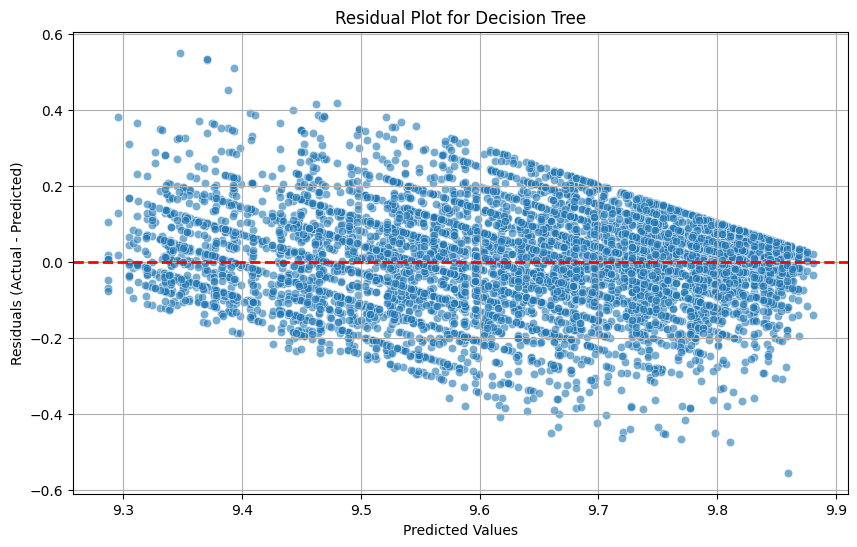

In [100]:
plot_residuals(y_test, y_pred_tree, "Decision Tree")

In [101]:

def plot_predicted_vs_actual(y_test, y_pred, model_name):
    """
    Plots the actual vs. predicted values of a regression model.

    Parameters:
    - y_test (pd.Series or np.array): The actual target values.
    - y_pred (pd.Series or np.array): The predicted values from the model.
    - model_name (str): The name of the model for the plot title.
    """
    plt.figure(figsize=(10, 6))
    
    # Create the scatter plot
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    
    # Plot the perfect 45-degree line (where y=x) for comparison
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2)
    
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'Predicted vs. Actual Plot for {model_name}')
    plt.grid(True)
    plt.show()
